In [22]:
import re
from typing import List, Tuple

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec, FastText
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from src.dataset import read_lang_dataset, tokenize_dataset, tokenize_document, get_vocab_mapping, gateways

sns.set_theme()
sns.set(rc={'figure.figsize': (12, 8)})

In [23]:
dataset = read_lang_dataset('data/dataset_github_codes.db')
dataset

,language,code
0,Python,"""""""The tests for the automation component.""""""\..."
1,Python,#!python2\n# -*- coding: utf-8 -*-\nimport os\...
2,Python,#!/usr/bin/python\n#\n# Copyright (c) 2017 Yuw...
3,Python,"""""""The tests for the Template automation.""""""\n..."
4,Python,"""""""The tests for numeric state automation.""""""\..."
...,...,...
9468,C#,using Microsoft.SharePoint.Client;\nusing Micr...
9469,C#,using System;\nusing System.Collections;\nusin...
9470,C#,using UnityEngine;\nusing System.Collections.G...
9471,C#,// Copyright (c) Microsoft Corporation. All ri...


In [24]:
dataset.language.value_counts()

C++       2688
C#        2494
Go        2203
Python    2088
Name: language, dtype: int64

In [25]:
use_cache = True
# load "tokenized_sample.pkl" from disk if it exists
if use_cache and os.path.exists("models/tokenized_sample.pkl"):
    tokenized_sample = pd.read_pickle("models/tokenized_sample.pkl")
else:
    tokenized_sample = tokenize_dataset(dataset)
    tokenized_sample.to_pickle("models/tokenized_sample.pkl")

tokenized_sample

,language,code
0,Python,"[STRING_LITERAL, \n, from, datetime, import, t..."
1,Python,"[\n, import, os, \n, import, sys, \n, import, ..."
2,Python,"[\n, from, __future__, import, absolute_import..."
3,Python,"[STRING_LITERAL, \n, import, unittest, \n, fro..."
4,Python,"[STRING_LITERAL, \n, from, datetime, import, t..."
...,...,...
9468,C#,"[using, Microsoft, ., SharePoint, ., Client, ;..."
9469,C#,"[using, System, ;, using, System, ., Collectio..."
9470,C#,"[using, UnityEngine, ;, using, System, ., Coll..."
9471,C#,"[using, System, ;, using, System, ., Collectio..."


In [26]:
def create_lang_model(dataset, complete_model, language):
    model = Word2Vec.load("models/complete_model.gensim")
    #model = FastText.load("models/complete_model.gensim")
    #model = Word2Vec(vector_size=100, window=10, min_count=10, workers=4)
    #model.reset_from(complete_model)
    #model.init_weights()
    train_dataset = dataset.code[dataset.language == language]
    model.train(train_dataset, total_examples=len(train_dataset), epochs=5)
    return model

In [27]:
common_keywords = ["if", "else", "for", "while", "class", "struct", "return", "continue", "break", "var", "try", "catch", "except"]
semantic_symbols = ["{", "}", ":"]

language_specific_words = common_keywords + semantic_symbols

In [28]:
from functools import partial


def add_language_prefix(code, language):
    return [f"{language}_{keyword}" if keyword in language_specific_words else keyword for keyword in code]

for language in tokenized_sample.language.unique():
    tokenized_sample.loc[tokenized_sample.language == language, "code"] = tokenized_sample[tokenized_sample.language == language].code.apply(partial(add_language_prefix, language=language))

In [29]:
#complete_model = FastText(vector_size=100, window=5, min_count=5, workers=8)
#complete_model = Word2Vec(vector_size=500, window=5, min_count=10, workers=8)
complete_model = FastText(vector_size=100, window=5, min_count=10, workers=8)
complete_model.build_vocab(tokenized_sample.code)
complete_model.train(tokenized_sample.code, total_examples=complete_model.corpus_count, epochs=5)
complete_model

# Visualize

In [30]:
inserted_tokens = ["INT_LITERAL", "FLOAT_LITERAL", "STRING_LITERAL", "VARIABLE"]
math_ops = ["+", "-", "*", "/", "%", "&&", "||", "!", "&", "|"]

python_keywords = ["def", "class", "return", "if", "else", "for", "while", "in", "import", "from", "as", "with", "try", "except", "finally", "raise", "assert", "yield", "lambda", "pass", "break", "continue", "del", "global", "nonlocal", "and", "or", "not", "is", "in", "True", "False", "None", "async", "await"]
cpp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
csharp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
go_keywords = ["break", "func", "default", "type", "defer", "go", "struct", "map", "chan", "else", "goto", "package", "range", "const", "fallthrough", "for", "import", "interface", "return", "select", "case", "continue", "if", "switch", "var", "nil", "true", "false"]

In [31]:
def word_cloud(model: Word2Vec, words):
    words = [word for word in words if word in model.wv.key_to_index.keys()]
    word_vectors = np.array([model.wv.get_normed_vectors()[model.wv.key_to_index[word]] for word in words])
    pca = PCA(n_components=2)
    result = pca.fit_transform(word_vectors)

    df = pd.DataFrame(result, columns=["x", "y"])
    df["model"] = [word.split("_")[0] if len(word.split("_")) == 2 else "" for word in words]
    ax = sns.scatterplot(data=df, x="x", y="y", hue="model")
    range_x, range_y = np.ptp(df[["x", "y"]], axis=0)
    keywords = [word.split("_")[1] if len(word.split("_")) == 2 else word for word in words]
    for i, word in enumerate(keywords):
        x, y = result[i]
        ax.text(x + 0.005 * range_x, y, word, verticalalignment='center', horizontalalignment='left', fontsize=8)
    return ax

<AxesSubplot: xlabel='x', ylabel='y'>

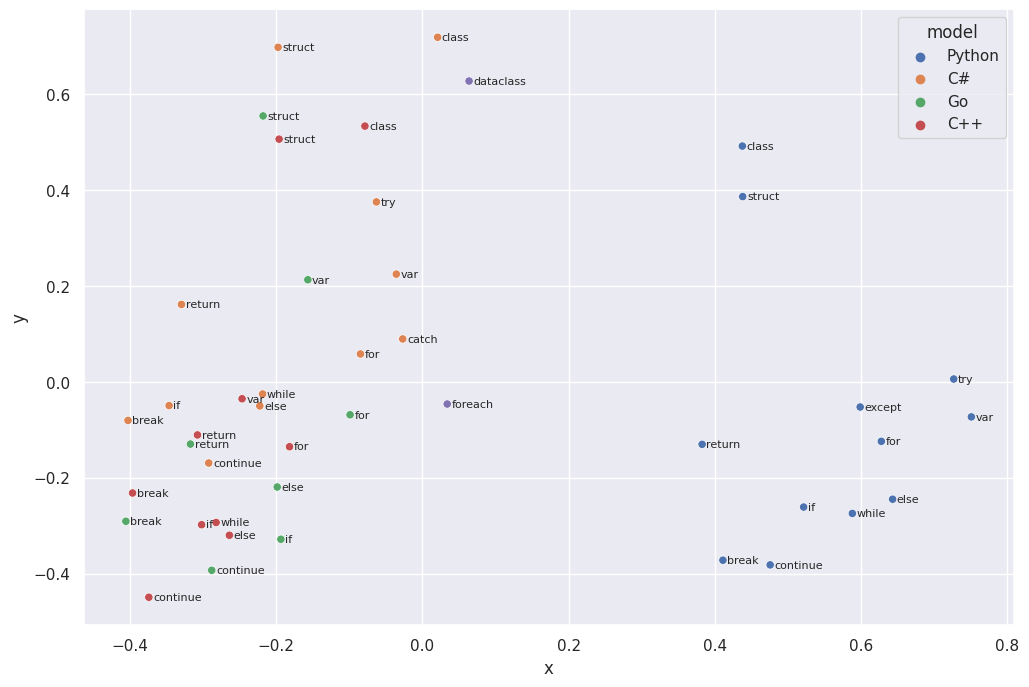

In [116]:
word_cloud(complete_model, [f"{language}_{w}" for w in common_keywords for language in tokenized_sample.language.unique()] + ["foreach", 'dataclass'])

In [33]:
complete_model.wv.most_similar(positive=["np", ".", "array", "Go", "VARIABLE"], negative=["Python", "C++", "C#"])

[('Subarray', 0.5229743123054504),
 ('scaleRandMin', 0.44184184074401855),
 ('array_group', 0.44164225459098816),
 ('scaleRandMax', 0.43539729714393616),
 ('First', 0.4271937608718872),
 ('scaleRandMaxUniform', 0.4252624213695526),
 ('arc', 0.4211727976799011),
 ('archive', 0.415865957736969),
 ('arch', 0.4151065945625305),
 ('sizeDelta', 0.4150189459323883)]

In [115]:
python_codes = tokenized_sample[tokenized_sample["language"] == 'Python']

python_model = FastText(vector_size=100, window=5, min_count=10, workers=8, sg=1)
python_model.build_vocab(python_codes.code)
python_model.train(python_codes.code, total_examples=python_model.corpus_count, epochs=5)
python_model


In [117]:
python_code_example = """#!/usr/bin/env python3

import os

def main():
    query = 7
    context = [3, 4, 10, 2, 8, 6, 5, 9, 7, 1]
    for i in range(len(context)):
        if context[i] == query:
            print(f'Query found at index {i}')
            os.exit(0)    

    print(f'Coulnd't find query {query}')
    os.exit(-1)


if __name__ == '__main__':
    main()

}"""

tokenized_code_example = tokenize_document(python_code_example, "Python")
for word in tokenized_code_example:
    print(f' {word}', end="")

def next_similar_token(token: str) -> str:
    next_most_similar_token, _ = complete_model.wv.most_similar(positive=[token])[0]
    return next_most_similar_token



next_similar_document = ' '.join([next_similar_token(t) for t in tokenized_code_example])
next_similar_document = next_similar_document.replace(':', ':\n')
print(next_similar_document)

complete_model.wv.most_similar(positive=['import', 'C++'], negative=['Python'])


100%|██████████| 1/1 [00:00<00:00, 37.77it/s]


 
 import os 
 def main ( ) :        VARIABLE = FLOAT_LITERAL   VARIABLE = [ FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL ]   for i in range ( len ( VARIABLE ) ) :            if VARIABLE [ i ] == VARIABLE :                print ( STRING_LITERAL )   os . exit ( FLOAT_LITERAL )       VARIABLE ( STRING_LITERAL VARIABLE VARIABLE VARIABLE { VARIABLE }   os . exit ( - FLOAT_LITERAL ) 
 
 if __name__ == STRING_LITERAL :        main ( ) 
 
 <EOF>

 importlib osp 

 ifsdef iommu_domain VARIANT_FALSE Trigger SanityCheckService Python_:
     VARIANT <<= INT_LITERAL Python_:
 VARIANT <<= splitlines INT_LITERAL PROTOBUF_C_TYPE_STRING INT_LITERAL PROTOBUF_C_TYPE_STRING INT_LITERAL PROTOBUF_C_TYPE_STRING INT_LITERAL PROTOBUF_C_TYPE_STRING INT_LITERAL PROTOBUF_C_TYPE_STRING INT_LITERAL PROTOBUF_C_TYPE_STRING INT_LITERAL PROTOBUF_C_TYPE_STRING INT_LITERAL PROTOBUF_C_TYPE_STRING INT_LITERAL P

[('C++_var', 0.5257896184921265),
 ('absolute_import', 0.5083414316177368),
 ('F_RDLCK', 0.4943324327468872),
 ('wzdImport', 0.4836500585079193),
 ('importlib', 0.4801184833049774),
 ('imports', 0.47849515080451965),
 ('peer_port', 0.4750911593437195),
 ('C++_break', 0.4733230471611023),
 ('dport', 0.4692630469799042),
 ('DllImport', 0.46720635890960693)]

In [104]:
recent_tokens = ['import', 'os']

#python_model.wv.most_similar_to_given

for i in range(20):
    next_tokens = python_model.predict_output_word(recent_tokens[-5:])

    token_found = False
    for t, _ in next_tokens:
        if t in recent_tokens[-5:] and t not in ['import', ',']:
            continue

        recent_tokens.append(t)
        print(t, end=' ')
        token_found = True

    if not token_found:
        t, _ = next_tokens[0]
        recent_tokens.append(t)
        print(t, end=' ')


path environ system abspath chdir mkdir sep dirname shutil realpath os rmtree path remoteLogFile shutil copyfile mkdtemp abspath normpath exists os path basename isdir dirname join shutil mkdtemp isfile path os rmtree shutil SQLMAP_SHELL_PATH filename join get_project_dir chdir path os file_name paths OutputDir get_project_dir SQLMAP_SHELL_PATH filename os path join chdir exists basename get_project_dir filename isdir file_name path Version category AlterField filename description file __file__ file_name remoteLogFile filename description path webutil name f escape scrub file_name description AlterField category filename field FieldDescriptor file f name migrations AlterField description filename file Descriptor AddField field FieldDescriptor category model_name name description number full_name myItem _descriptor Str category description weight number name Descriptor where itemID index description category myItem file weight number FieldDescriptor Descriptor full_name category descrip

Number to different tokens: 36150


Text(0, 0.5, 'Vocabulary size')

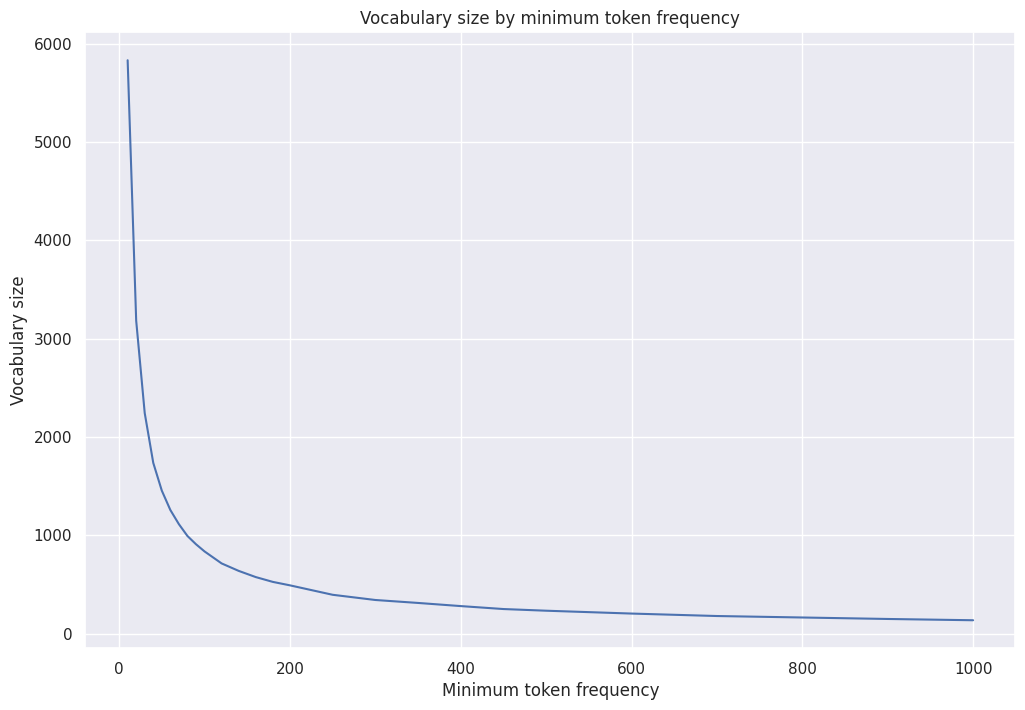

In [152]:
token_frequency = {}
for code in python_codes.code:
    for token in code:
        token_frequency[token] = token_frequency.get(token, 0) + 1
print(f'Number to different tokens: {len(token_frequency)}')

token_frequency_meta = {}
for m in [10,20,30,40,50,60,70,80,90,100, 120, 140, 160, 180, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]:
    for token, freq in token_frequency.items():        
        if freq >= m:
            token_frequency_meta[m] = token_frequency_meta.get(m, 0) + 1

plt.plot(list(token_frequency_meta.keys()), list(token_frequency_meta.values()))
plt.title('Vocabulary size by minimum token frequency')
plt.xlabel('Minimum token frequency')
plt.ylabel('Vocabulary size')
